In [454]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tqdm

### The project:

MNIST Classifier from scratch, without using the inbuilt layers, activations, losses, etc using the subclassing API with a custom loop.

Before which let's first create a MNIST classifier with all these:


In [6]:
(X_train, y_train,), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# scale the values to be within [0, 1]
X_train = X_train / 255.0
X_test = X_test /  255.0

# printing out the shapes
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

### Let's create the model using the functional API:
We are trying to implement a 'Deep and Wide' neural network to add complexity for our custom model.

In [7]:
# creating the input layer
inp = tf.keras.layers.Input(shape=(28, 28))
# flatten the inputs 
flatten = tf.keras.layers.Flatten()(inp)

# dense layer blocks
dense1 = tf.keras.layers.Dense(units=128, activation='elu', kernel_initializer='he_normal')(flatten)
dense2 = tf.keras.layers.Dense(units=128, activation='elu', kernel_initializer='he_normal')(dense1)

# we concatenate two consequtive layers and feed it to a drop out layer
conc = tf.keras.layers.Concatenate()([dense1, dense2])

# drop out layer
dropout1 = tf.keras.layers.Dropout(0.2)(conc)

# final dense which then feeds to the output layer which does predictions
dense3  = tf.keras.layers.Dense(units=256, activation='elu', kernel_initializer='he_normal')(dropout1)

# the output layer making predictions
op = tf.keras.layers.Dense(10, activation='softmax')(dense3)

# create the functional api model
model = tf.keras.models.Model(name='Deep_N_Wide_Model', inputs=[inp], outputs=[op])

# compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.001),
             metrics=tf.keras.metrics.SparseCategoricalAccuracy(name='SCAcc'))

# let's print out the summary of model
model.summary()

Model: "Deep_N_Wide_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 784)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          100480      flatten[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________

Perhaps an visual flowchart might help us better see the model:

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

#### Let's train our model:

In [9]:
hist = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
1875/1875 [==============================] - 19s 10ms/step - loss: 0.2538 - SCAcc: 0.9224 - val_loss: 0.1500 - val_SCAcc: 0.9520 - lr: 0.0010
Epoch 2/20
1875/1875 [==============================] - 18s 9ms/step - loss: 0.1277 - SCAcc: 0.9599 - val_loss: 0.1176 - val_SCAcc: 0.9624 - lr: 0.0010
Epoch 3/20
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0984 - SCAcc: 0.9688 - val_loss: 0.1117 - val_SCAcc: 0.9683 - lr: 0.0010
Epoch 4/20
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0814 - SCAcc: 0.9753 - val_loss: 0.0921 - val_SCAcc: 0.9708 - lr: 0.0010
Epoch 5/20
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0367 - SCAcc: 0.9877 - val_loss: 0.0605 - val_SCAcc: 0.9826 - lr: 1.0000e-04
Epoch 6/20
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0275 - SCAcc: 0.9915 - val_loss: 0.0569 - val_SCAcc: 0.9829 - lr: 1.0000e-04
Epoch 7/20
1875/1875 [==============================] - 17s 9ms/step - loss:

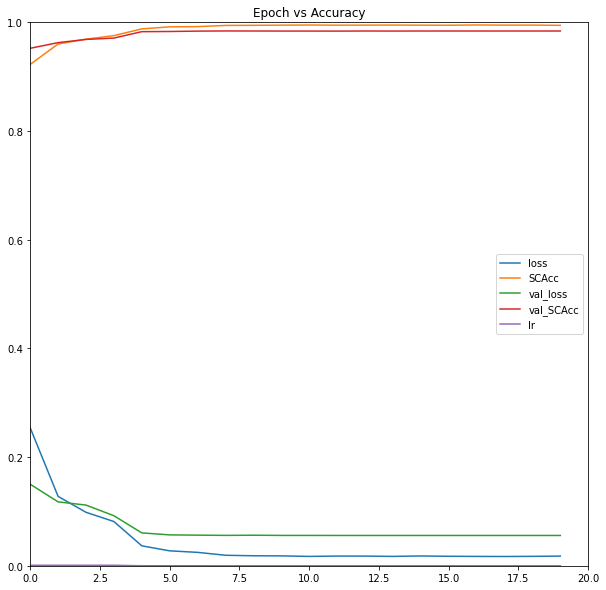

In [42]:
# visualise the models training performance
pd.DataFrame(hist.history).plot(figsize=(10, 10), ylim=[0, 1], xlim=[0, 20], title='Epoch vs Accuracy');

### Now let's create the model we created above from scratch using subclassing API:

#### Loss functions:

In [474]:
class my_cross_entropy(tf.keras.losses.Loss):
    '''Cross entropy loss, loss layers inherit from keras.losses.loss class.
    Requires one hot encoded targets'''
    
    def __init__(self, epsilon=1e-12, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon
    
    def call(self, y_true, y_pred):
        pred = tf.clip_by_value(y_pred, self.epsilon, 1.0 - self.epsilon)
        N = pred.shape[0]
        ce = -tf.reduce_sum(tf.math.log(pred) * y_true) / N
        
        return ce
        
    def get_config(self):
        # this is a must if we hope to save our model someday
        return {**super().get_config(), "epsilon": self.epsilon}

In [475]:
class my_s_cross_entropy(tf.keras.losses.Loss):
    '''Same as above but sparse_crossentropy loss.
    Takes in sparse targets.'''
    
    def __init__(self, epsilon=1e-12, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon
    
    def call(self, y_true, y_pred):
        
        # one hot encode the targets and squeeze any dimensions of value 1
        y_true = tf.squeeze(tf.one_hot(y_true, depth=y_pred.shape[-1]))
        
        # exactly copied from above loss snippet
        pred = tf.clip_by_value(y_pred, self.epsilon, 1.0 - self.epsilon)
        N = pred.shape[0]
        
        # we add the epsilon value since the model loss 
        # hits NAN when trained for longer periods
        ce = -tf.reduce_sum(tf.math.log(pred + 1e-9) * y_true) / N
        
        return ce
        
    def get_config(self):
        return {**super().get_config(), "epsilon": self.epsilon}

In [476]:
# assume to be the model's predictions
predictions = np.array([[0.05 , 0.95, 0],
                        [0.1, 0.8, 0.1]], dtype=np.float32)

# sparse targets (actual)
s_targets = np.array([[1], [2]], dtype=np.float32)

# one hot encoded targets (actual)
targets = np.array([[0., 1., 0.], [0., 0., 1.]], dtype=np.float32)

##### Compare the outputs of keras implementation with ours:

In [477]:
cce = tf.keras.losses.CategoricalCrossentropy()
print ("Keras Output:", cce(targets, predictions).numpy())
print ("Our Output:", my_cross_entropy()(targets, predictions).numpy())

Keras Output: 1.1769392
Our Output: 1.1769392


In [478]:
sce = tf.keras.losses.SparseCategoricalCrossentropy()
print ("Keras Output:", sce(s_targets, predictions).numpy())
print ("Our Output:", my_s_cross_entropy()(s_targets, predictions).numpy())

Keras Output: 1.1769392
Our Output: 1.1769392


Working good, let's move on to create the SparseCategoricalAccuracy Metric

### Metrics:

In [418]:
class my_scacc_metric(tf.keras.metrics.Metric):
    '''Creating a stateful metric, which keeps updating itself with streaming scores.
    No args to init, hence get_config is not needed.'''
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
        # intialize total & count to calculate the mean when required
        self.total = self.add_weight("total", initializer='zeros')
        self.count = self.add_weight("count", initializer='zeros')
        
        # creating the metric from function we have already defined, redundant
        self.calc_acc = my_scacc_metric.my_SCAcc
        
    def update_state(self, y_true, y_pred, sample_weights=None):
        '''Gets called inside the loop for every step of the epoch'''
        
        metrics = self.calc_acc(y_true, y_pred)
        
        # update the total scores along with count for later purpose
        self.total.assign_add(tf.reduce_sum(metrics))
        self.count.assign_add(tf.cast(tf.size(y_true), dtype=tf.float32))
    
    def my_SCAcc(y_true, y_pred):
        scores = tf.cast(tf.equal(
            tf.cast(tf.reduce_max(y_true, axis=-1), dtype=tf.float32), 
            tf.cast(tf.argmax(y_pred, axis=-1), dtype=tf.float32),
        ), dtype=tf.float32)
        
        return scores
    
    def result(self):
        '''Gets called at the end of epoch. Calculate the mean'''
        return self.total / self.count

In [479]:
targets = [[2], [1]]
predictions = [[0.1, 0.9, 0.8], [0.05, 0.95, 0]]
temp = my_scacc_metric()
temp.update_state(targets, predictions)
temp.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

### Activations:
Metrics is working fine, let's move on to creating our own activations for `Softmax` & `elu`:

In [420]:
class my_elu(tf.keras.layers.Layer):
    def __init__(self, alpha=1., **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha
        
    def call(self, z):
        
        z = tf.cast(z, dtype=tf.float32)
        return tf.where(z > 0, z, self.alpha * (tf.exp(z) - 1))
            
    def get_config(self):
        return {**super().get_config(), "alpha": self.alpha}
    

In [421]:
my_elu()(tf.constant([-1, -9, 10, 20]))

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([-0.63212055, -0.9998766 , 10.        , 20.        ], dtype=float32)>

In [422]:
len(tf.shape(tf.constant([[1, 2, 3], [2, 3, 4]])))

2

In [423]:
def my_softmax(z, axis=-1):    
    ndim = len(tf.shape(z))
    if ndim == 2:
        return tf.nn.softmax(z)
    elif ndim > 2:
        e = tf.exp(z - tf.reduce_max(z, axis=axis, keepdims=True))
        s = tf.reduce_sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        raise ValueError('Cannot apply softmax to a tensor that is 1D. '
                         'Received input: %s' % z)

In [424]:
my_softmax(tf.constant([[1., 2., 3.]]))

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.09003057, 0.24472848, 0.66524094]], dtype=float32)>

### Initializers:
Let's now move on to create the golorot normal and he_normal intializers for the model:

In [425]:
def my_glorot_init(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

In [426]:
my_glorot_init([10,1])

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[ 0.6974226 ],
       [-0.35105956],
       [-0.2997724 ],
       [ 0.1749831 ],
       [ 0.46001196],
       [ 0.44626623],
       [-0.27885336],
       [-0.31279862],
       [-0.44361517],
       [ 0.8710123 ]], dtype=float32)>

In [427]:
def my_he_init(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / shape[0])
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

In [428]:
my_he_init([10, 1])

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[-0.05962639],
       [ 0.24382487],
       [ 0.47306964],
       [ 0.37291068],
       [-0.6868492 ],
       [ 0.17765294],
       [-0.07778834],
       [ 0.29282498],
       [-1.0894686 ],
       [-0.31218007]], dtype=float32)>

### Custom layers:


In [429]:
class my_dense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None, initializer=None, **kwargs):
        self.units = units
        super().__init__(**kwargs)
        
        if not activation:
            self.activation = my_elu()
        else:
            self.activation = activation
        
        if not initializer:
            self.my_init = my_he_init
        else:
            self.my_init = initializer        
        
    def build(self, batch_input_shape):
        self.kernel = self.add_weight(name='kernel', shape=[batch_input_shape[-1], self.units], initializer=self.my_init)
        self.bias = self.add_weight(name='bias', shape=[self.units], initializer='zeros')
        super().build(batch_input_shape)
        
    def call(self, x):
        return self.activation(x @ self.kernel + self.bias)
    
    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1], [self.units])
    
    def get_config(self):
        parent_configs = super().get_config()
        return {**parent_configs, 
                "units": self.units,
                "activation": tf.keras.activations.serialize(self.activation),
                "initializer": tf.keras.initializers.serialize(self.my_init),
               }

In [430]:
temp = my_dense(units=10)
temp(tf.random.normal(shape=(5,1)))

<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[ 1.1428204 , -0.0751465 , -0.6035164 , -0.9171566 ,  1.1909186 ,
        -0.7876803 , -0.64899766,  0.32825693,  0.8364202 ,  0.5899803 ],
       [-0.65485215,  0.07271709,  0.86113876,  2.318538  , -0.6699641 ,
         1.4424869 ,  0.97455406, -0.26328528, -0.54093933, -0.42257512],
       [-0.83045304,  0.12130825,  1.4365708 ,  3.8678362 , -0.84265494,
         2.4063885 ,  1.6257726 , -0.39934397, -0.72714984, -0.59994334],
       [-0.8056033 ,  0.11195901,  1.3258541 ,  3.5697417 , -0.8185522 ,
         2.220928  ,  1.5004741 , -0.37527746, -0.6984234 , -0.57067513],
       [ 2.0640433 , -0.1315906 , -0.81191415, -0.98887575,  2.1509132 ,
        -0.9391193 , -0.8490664 ,  0.59286356,  1.5106552 ,  1.065561  ]],
      dtype=float32)>

In [431]:
temp = my_dense(units=10, activation=my_softmax, initializer=my_glorot_init)
temp(tf.random.normal(shape=(5,1)))

<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[0.10680518, 0.04703631, 0.10234663, 0.09287959, 0.04294725,
        0.11431344, 0.15661128, 0.10840799, 0.15948589, 0.06916639],
       [0.07417963, 0.1906956 , 0.07791227, 0.08712405, 0.21174625,
        0.06859852, 0.04774178, 0.07291834, 0.0467524 , 0.12233116],
       [0.06541538, 0.2167421 , 0.06961959, 0.08022454, 0.24753709,
        0.05923524, 0.03739871, 0.06400742, 0.03641813, 0.12340179],
       [0.08537249, 0.15511   , 0.08806465, 0.09451346, 0.165729  ,
        0.08125221, 0.06460769, 0.08445159, 0.06375772, 0.11714119],
       [0.10568273, 0.06750244, 0.1032479 , 0.09791277, 0.06422868,
        0.10968118, 0.13027751, 0.10654672, 0.13157924, 0.08334084]],
      dtype=float32)>

In [432]:
class my_dropout(tf.keras.layers.Layer):
    def __init__(self, drate, **kwargs):
        self.drate = drate
        super().__init__(**kwargs)
        
    def call(self, inputs, training=None):
        if training:
            mask = tf.random.uniform(shape=inputs.shape) > self.drate
            return tf.where(mask, inputs, 0) / (1 - self.drate)
        
        else:
            return inputs
        
    def get_config(self):
        return {**super().get_config(), "drate": self.drate}
        

In [433]:
with tf.keras.backend.learning_phase_scope(1):
    temp = my_dropout(0.2)(tf.random.normal(shape=(10,)))
    print (temp.shape)
    print (temp)

(10,)
tf.Tensor(
[-1.5063496   0.          0.39664894  0.         -0.54375064 -0.5133027
 -1.3359358   0.          0.          0.        ], shape=(10,), dtype=float32)


In [434]:
class my_flatten(tf.keras.layers.Layer):
    def call(self, x):
        return tf.reshape(x, shape=[x.shape[0], -1])
    
    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape([batch_input_shape[0]], [tf.reduce_prod(batch_input_shape[1:])])

In [435]:
my_flatten()(X_train[:10].astype(np.int32))

<tf.Tensor: shape=(10, 784), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>

In [436]:
class my_conc(tf.keras.layers.Layer):
    def call(self, inputs):
        a, b = inputs
        return tf.concat([a, b], axis=1)
    
    def compute_output_shape(self, batch_input_shapes):
        return tf.TensorShape(batch_input_shapes[0][:-1], [batch_input_shapes[0][-1] + batch_input_shapes[1][-1]])

In [437]:
my_conc()([tf.random.uniform(shape=(5, 2)), tf.random.uniform(shape=(5, 3))])

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0.34733737, 0.50976706, 0.92616856, 0.42780864, 0.82958376],
       [0.48532736, 0.12041569, 0.8498498 , 0.2160269 , 0.3847556 ],
       [0.9411465 , 0.5607525 , 0.5391358 , 0.7781346 , 0.00567448],
       [0.23165798, 0.10524464, 0.62537086, 0.6577296 , 0.26813507],
       [0.28594744, 0.6244042 , 0.04825294, 0.8871002 , 0.33091247]],
      dtype=float32)>

We are done creating the layers, let's now create the model using subclass api.
### Model creation:

In [438]:
class my_mnist_model(tf.keras.models.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
        self.flatten = my_flatten()
        self.dense1 = my_dense(units=128)
        self.dense2 = my_dense(units=128)
        self.conc = my_conc()
        self.dropout = my_dropout(drate=0.2)
        self.dense3 = my_dense(units=256)
        self.op = my_dense(units=10, initializer=my_glorot_init, activation=my_softmax)
        
    def call(self, inputs):
        
        flatten = self.flatten(inputs)
        dense1 = self.dense1(flatten)
        dense2 = self.dense2(dense1)
        conc = self.conc([dense1, dense2])
        dropout = self.dropout(conc)
        dense3 = self.dense3(dropout)
        op = self.op(dense3)
        
        return op              

In [439]:
tf.keras.backend.clear_session()

In [440]:
with tf.keras.backend.learning_phase_scope(1):
    temp = my_mnist_model()
    print (temp(X_train[:50].astype(np.float32)).shape)

(50, 10)


### Model Training (Custom loop)
Now let's get the model to train for which let's write a function that prints out the metrics during training:

In [461]:
def print_status_bar(iteration, total, loss, metrics=None):
    metrics = ' - '.join(["{}: {:.4f}".format(m.name, m.result()) for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print ("\r{}/{} - ".format(iteration, total) + metrics, end=end)

In [469]:
tf.keras.backend.clear_session()
my_model = my_mnist_model()
optimizer = tf.keras.optimizers.Adam(0.001)
metrics = [my_scacc_metric()]
loss_fn = my_s_cross_entropy()
mean_loss = tf.keras.metrics.Mean(name='Loss_Mean')

n_epochs = 20
batch_size = 32

n_steps_train = len(X_train) // batch_size
n_steps_test = len(X_test) // batch_size

X_Train = X_train.astype(np.float32)
y_Train = y_train.reshape(-1, 1)

X_Test = X_test.astype(np.float32)
y_Test = y_test.reshape(-1, 1)

In [470]:
for epoch in range(1, n_epochs + 1):
    if epoch != 1:
        print ("\n\n")
    print ("Epoch {}/{}:".format(epoch, n_epochs))
    ids = tf.random.shuffle(tf.range(start=0, limit=len(X_train)))
    
    for step in range(1, n_steps_train + 1):
        temp_ids = ids[(step-1)*batch_size: step*batch_size]
        X_batch, y_batch = X_Train[temp_ids], y_Train[temp_ids]        
        with tf.GradientTape() as tape:
            y_pred = my_model(X_batch, training=True)
            main_loss = loss_fn(y_batch, y_pred)
            loss = tf.add_n([main_loss] + my_model.losses)
        gradients = tape.gradient(loss, my_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, my_model.trainable_variables))
        mean_loss(loss)
        for metric in metrics:
            metric(y_batch, y_pred)
        print_status_bar(step * batch_size, len(y_train), mean_loss, metrics)
        
    for metric in [mean_loss] + metrics:
        metric.reset_states()
    
    for step in range(1, n_steps_test + 1):
        X_batch = X_Test[(step - 1)*batch_size: step * batch_size]
        y_batch = y_Test[(step - 1)*batch_size: step * batch_size]
        
        y_pred = my_model(X_batch, training=False)
        val_loss = loss_fn(y_batch, y_pred)
        
        mean_loss(val_loss)
        for metric in metrics:
            metric(y_batch, y_pred)
            
        print_status_bar(step * batch_size, len(y_Test), mean_loss, metrics)
    
    for metric in [mean_loss] + metrics:
        metric.reset_states()

Epoch 1/20:
60000/60000 - mean: 0.2591 - my_scacc_metric: 0.9211
9984/10000 - mean: 0.1377 - my_scacc_metric: 0.9567


Epoch 2/20:
60000/60000 - mean: 0.1298 - my_scacc_metric: 0.9593
9984/10000 - mean: 0.1108 - my_scacc_metric: 0.9656


Epoch 3/20:
60000/60000 - mean: 0.0952 - my_scacc_metric: 0.9703
9984/10000 - mean: 0.0959 - my_scacc_metric: 0.9704


Epoch 4/20:
60000/60000 - mean: 0.0810 - my_scacc_metric: 0.9745
9984/10000 - mean: 0.0858 - my_scacc_metric: 0.9743


Epoch 5/20:
60000/60000 - mean: 0.0697 - my_scacc_metric: 0.9780
9984/10000 - mean: 0.0973 - my_scacc_metric: 0.9737


Epoch 6/20:
60000/60000 - mean: 0.0617 - my_scacc_metric: 0.9805
9984/10000 - mean: 0.0949 - my_scacc_metric: 0.9752


Epoch 7/20:
60000/60000 - mean: 0.0551 - my_scacc_metric: 0.9826
9984/10000 - mean: 0.0998 - my_scacc_metric: 0.9722


Epoch 8/20:
60000/60000 - mean: 0.0476 - my_scacc_metric: 0.9852
9984/10000 - mean: 0.0926 - my_scacc_metric: 0.9764


Epoch 9/20:
60000/60000 - mean: 0.0460 - my_scac